### Install Deep Lake
Repo is here: https://github.com/activeloopai/deeplake
API reference is here: https://docs.deeplake.ai/

In [46]:
from IPython.display import clear_output
import sys
print(sys.executable)
!{sys.executable} -m pip install --quiet deeplake google-cloud-storage nibabel
clear_output()

# restart kernel after that

## Example how to create Deep Lake datasets with data straight from a bucket
[ ] PREREQUISITE: Put Medical Decathlon dataset into a bucket

In [5]:
import deeplake
from google.cloud import storage
import nibabel as nib
import numpy as np
import os
from tqdm import tqdm
import tempfile
import subprocess

import multiprocessing


import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output


# PRE-REQUISITE: PUT Medical Decathlon dataset into a bucket

PROJECT_BUCKET = os.getenv("PROJECT_BUCKET")
FOLDER = "Medical_Decathalon"
PREFIX = "Medical_Decathlon_02_Heart_Segmentation"

Optional: Download to local (just to explore)

In [ ]:
from IPython.display import clear_output
HOME = os.getenv("HOME")
!gsutil -m cp -r gs://$PROJCET_BUCKET/$FOLDER/$PREFIX $HOME
clear_output()

### Create a Deep Lake dataset

In [7]:
client = storage.Client()
file_list=[]
for blob in client.list_blobs(PROJECT_BUCKET, prefix=PREFIX):
    file_list.append(blob.name)

In [8]:
train_img = [i for i in file_list if "imagesTr" in i]
train_mask = [i for i in file_list if "labelsTr" in i]
test_img = [i for i in file_list if "imagesTs" in i]

In [9]:
def read_nii(filename):
    _, dlfilename = tempfile.mkstemp(suffix='.nii.gz')
    subprocess.call(["gsutil", "cp", filename, dlfilename])
    img_array = nib.load(dlfilename).get_fdata()
    os.remove(dlfilename)
    return img_array

### Creation of the dataset

it's also possible to point to a local location (e.g. /mnt/)

In [33]:
# for demo purpose, we always want to start from scratch (hence the check whether dataset already exists; if TRUE then delete)

try: 
     ds = deeplake.empty('gcs://{}/{}/heart_segm_hub'.format(PROJECT_BUCKET, PREFIX), overwrite=True) 
except:
     deeplake.delete('gcs://{}/{}/heart_segm_hub'.format(PROJECT_BUCKET, PREFIX), force=True)
     ds = deeplake.empty('gcs://{}/{}/heart_segm_hub'.format(PROJECT_BUCKET, PREFIX), overwrite=True)

with ds:
    # put in dataset metadata
    ds.info.update(project = 'Hello World', 
                   author = 'Steffen',
                   notes = "only train set included")
    ds.create_group("train") # used if we want to put train/val/test in different "tensor"-groups
    ds.train.create_tensor("image", htype="image", sample_compression=None)
    ds.train.create_tensor("mask", htype="image", sample_compression=None)
    for i, fn in enumerate(tqdm(train_img)):
        ds.train.image.append(read_nii(os.path.join("gs://", PROJECT_BUCKET, fn)).astype(np.uint8))
        mask_name = [i for i in train_mask if fn.split('/')[-1] in i][0]
        ds.train.mask.append(read_nii(os.path.join("gs://", PROJECT_BUCKET, mask_name)).astype(np.uint8))

clear_output()

For parallel computing it is very similar like shown above (see https://docs.activeloop.ai/getting-started/parallel-computing)

In [34]:
# build function with hub decorator that accepts filename and output ds + optional arguments (in our case the)
# mask_list to find the right mask file and the PROJECT_BUCKET name to read

@deeplake.compute
def ds_creation_para(img_name, ds, mask_list, bucket_name):
    ds.train.image.append(read_nii(os.path.join("gs://", bucket_name, fn)).astype(np.uint8))
    mask_name = [i for i in mask_list if fn.split('/')[-1] in i][0]
    ds.train.mask.append(read_nii(os.path.join("gs://", bucket_name, mask_name)).astype(np.uint8))
    return ds

In [35]:
ds_para = deeplake.empty('gcs://{}/{}/heart_segm_hub_parallel'.format(PROJECT_BUCKET, PREFIX), overwrite=True) 

num_cpu = multiprocessing.cpu_count()
print ("Processing with {} cpus".format(num_cpu))

with ds_para:
    # put in dataset metadata
    ds_para.info.update(project = 'Hello World', 
                   author = 'Steffen',
                   notes = "only train set included")
    ds_para.create_group("train") #used if we want to put train/val/test in different "tensor"-groups
    ds_para.train.create_tensor("image", htype="image", sample_compression=None)
    ds_para.train.create_tensor("mask", htype="image", sample_compression=None)
    ds_creation_para(mask_list=train_mask, bucket_name = PROJECT_BUCKET).eval(train_img, ds_para, num_workers= num_cpu)

clear_output()

In [36]:
ds_para.log()

---------------
Deep Lake Version Log
---------------

Current Branch: main
** There are uncommitted changes on this branch.



In [37]:
ds_para.commit("initial commit")

'firstdbf9474d461a19e9333c2fd19b46115348f'

In [38]:
ds_para.log()

---------------
Deep Lake Version Log
---------------

Current Branch: main

Commit : firstdbf9474d461a19e9333c2fd19b46115348f (main) 
Author : public
Time   : 2023-02-23 09:42:14
Message: initial commit



In [39]:
print(ds_para.tensors)
print(ds_para.groups)
print(ds_para.info)
print("Current commit_id: {}".format(ds_para.commit_id))

{'train/image': Tensor(key='train/image'), 'train/mask': Tensor(key='train/mask')}
{'train': Dataset(path='gcs://curveballai-bucket-113707/Medical_Decathlon_02_Heart_Segmentation/heart_segm_hub_parallel', group_index='train', tensors=['image', 'mask'])}
{'author': 'Steffen', 'notes': 'only train set included', 'project': 'Bayer Hello World'}
Current commit_id: firstdbf9474d461a19e9333c2fd19b46115348f


### Read dataset and visualize a sample

In [40]:
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, origin="lower")

Text(0.5, 0.98, 'Center slice and corresponding mask; image has dimension (320, 320, 110)')

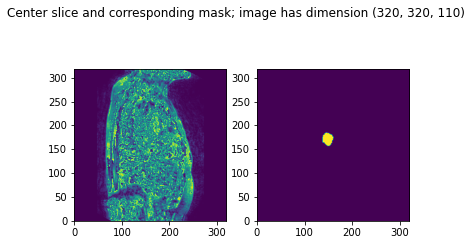

In [41]:
ind = 1

scan_image = ds_para.train.image[ind].numpy()
mask_image = ds_para.train.mask[ind].numpy()
center_slice_index = scan_image.shape[2]//2
center_slice = scan_image[:, :, int(center_slice_index*1.5)] # the factor *1.5 is just to move a bit up from the center line in order to find the mask
center_slice_mask = mask_image[:, :, int(center_slice_index*1.5)]
show_slices([center_slice, center_slice_mask])
plt.suptitle("Center slice and corresponding mask; image has dimension {}".format(scan_image.shape)) 

### For model training you can load the dataset from the project bucket directly

In [42]:
%time ds_new = deeplake.load('gcs://{}/{}/heart_segm_hub_parallel'.format(PROJECT_BUCKET, PREFIX))

gcs://curveballai-bucket-113707/Medical_Decathlon_02_Heart_Segmentation/heart_segm_hub_parallel loaded successfully.
CPU times: user 134 ms, sys: 5.37 ms, total: 140 ms
Wall time: 720 ms


CPU times: user 99 ms, sys: 17.9 ms, total: 117 ms
Wall time: 375 ms


Text(0.5, 0.98, 'Center slice and mask; image has dimension (320, 320, 110)')

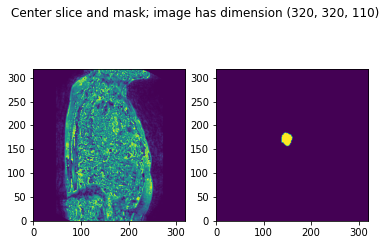

In [43]:
ind = 1

%time scan_image = ds_new.train.image[ind].numpy()
mask_image = ds_new.train.mask[ind].numpy()
center_slice_index = scan_image.shape[2]//2
center_slice = scan_image[:, :, int(center_slice_index*1.5)] # the factor *1.5 is just to move a bit up from the center line in order to find the mask
center_slice_mask = mask_image[:, :, int(center_slice_index*1.5)]
show_slices([center_slice, center_slice_mask])
plt.suptitle("Center slice and mask; image has dimension {}".format(scan_image.shape)) 

### Let's append the test data, add dummy class labels to train and make a commit

In [44]:
ds = deeplake.load('gcs://{}/{}/heart_segm_hub_parallel'.format(PROJECT_BUCKET, PREFIX))

import random 
print(len(test_img)) #created above
dummy_labels = ["lung", "liver", "heart", "pancreas"]

with ds:
    ds.create_group("test", exist_ok=True) #used if we want to put train/val/test in different "tensor"-groups
    ds.test.create_tensor("image", htype="image", sample_compression=None, exist_ok=True)
    for fn in tqdm(test_img):
        ds.test.image.append(read_nii(os.path.join("gs://", PROJECT_BUCKET, fn)).astype(np.uint8))
        
    ds.train.create_tensor("class_label", htype="text")
    for i in range(ds_new.train.image.shape[0]):
        ds.train.class_label.append(random.choice(dummy_labels))
        
commit_id = ds.commit('test data and dummy labels added')
# Print the commit log
log = ds.log()

gcs://curveballai-bucket-113707/Medical_Decathlon_02_Heart_Segmentation/heart_segm_hub_parallel loaded successfully.
10


100%|██████████| 10/10 [00:42<00:00,  4.25s/it]


---------------
Deep Lake Version Log
---------------

Current Branch: main

Commit : ac828976b4ca43429a1ec3dcfd3c3b68d77d8562 (main) 
Author : public
Time   : 2023-02-23 09:44:22
Message: test data and dummy labels added

Commit : firstdbf9474d461a19e9333c2fd19b46115348f (main) 
Author : public
Time   : 2023-02-23 09:42:14
Message: initial commit



### Let's check the new dummy label tensor

heart


Text(0.5, 0.98, 'Center slice and mask; dummy label is heart; image has dimension (320, 320, 110)')

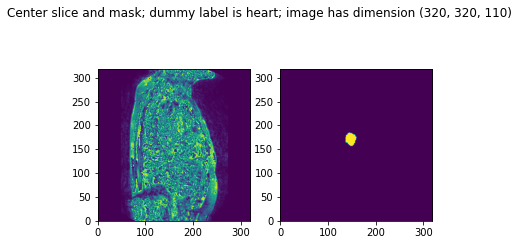

In [45]:
ind = 1

scan_image = ds.train.image[ind].numpy()
mask_image = ds.train.mask[ind].numpy()
label = ds.train.class_label[ind].numpy()
print(label[0])
center_slice_index = scan_image.shape[2]//2
center_slice = scan_image[:, :, int(center_slice_index*1.5)] # the factor *1.5 is just to move a bit up from the center line in order to find the mask
center_slice_mask = mask_image[:, :, int(center_slice_index*1.5)]
show_slices([center_slice, center_slice_mask])
plt.suptitle("Center slice and mask; dummy label is {}; image has dimension {}".format(label[0], scan_image.shape)) 

### Versioning

In [ ]:
# # Checkout a branch or commit 
#ds.checkout('label_bug_fixes' or commit_id)

# # Create a new branch
#ds.checkout('new_branch', create = True)